# Blog Post: 'Optimal' Decision Making

In this blog post, I aim to analyze data regarding the likelihood that the bank will grant a loan based on a group of personal attributes. First, I will find explore the data set to observe trends, and then I will determine the best attributes for successfully predicted whether a borrower will default on a loan. Then, I will build a model and determine an ideal threshold before analyzing the test data. Finally, I will observe the accuracy and profit with which my model performs on the test data from the point of view of the bank and the borrower.

Once again, to begin, the training data must be accessed.

In [41]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

Here's a look at the data:

In [42]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


Time to clean the data and take another look. I won't one hot encode the columns yet, because I'm going to use some of them to explore the data set.

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train['loan_status'])

def prepare_data(df):
    df = df.drop(['loan_grade'], axis=1)
    df = df.dropna()
    y = le.fit_transform(df['loan_status'])
    df = df.drop(['loan_status'], axis = 1)

    return df, y

X_train, y_train = prepare_data(df_train)
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,11750,13.47,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,10000,7.51,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,1325,12.87,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,15000,9.63,0.28,N,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,5500,14.91,0.25,N,2


### Exploring the Data

Let's get familiar with some of the attributes and decide which ones might be helpful to predict whether someone defaulted on a loan or not.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

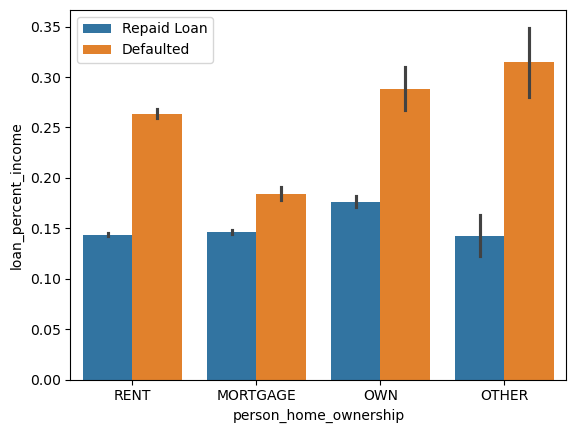

In [45]:
x = X_train['person_home_ownership']
y = X_train['loan_percent_income']

ax = sns.barplot(data=X_train, x = 'person_home_ownership', y = 'loan_percent_income', hue = y_train.astype(str))

h,l = ax.get_legend_handles_labels()
l = ["Repaid Loan", "Defaulted"]
ax.legend(h, l)

plt.show()

Looking at different types of home ownership, it looks like the percent income of the loan plays a really big role in whether or not it gets defaulted.

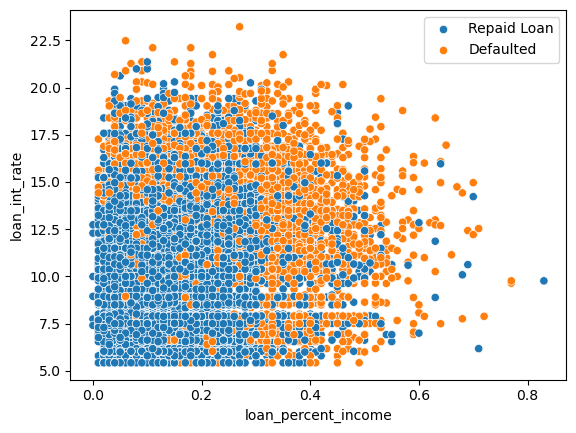

In [46]:
x = X_train['loan_percent_income']
y = X_train['loan_int_rate']

ax = sns.scatterplot(data=X_train, x = 'loan_percent_income', y = 'loan_int_rate', hue = y_train.astype(str))

h,l = ax.get_legend_handles_labels()
l = ["Repaid Loan", "Defaulted"]
ax.legend(h, l)

plt.show()

Well, unsurprisingly, it looks like the chance that a loan is fully repaid is increased as the interest rate falls, and as the percentage of a person's income falls.

In [47]:
X_train.groupby([y_train, 'cb_person_default_on_file'])[['person_emp_length', 'cb_person_cred_hist_length']].mean()

person_emp_length  cb_person_cred_hist_length
  cb_person_default_on_file                                               
0 N                                   4.987118                    5.809296
  Y                                   4.782471                    5.928938
1 N                                   4.161868                    5.603114
  Y                                   4.166886                    5.735217

People who repaid the loan fully have generally been employed for a bit longer. I was surprised by how little difference it made to have a previous default on file. Also, while credit history length decreased slightly for loans that were defaulted, it didn't seem to be by a significant amount.

### Building a Model

Now that I'm ready to start modeling, I'll go ahead an one hot encode any qualitative columns.

In [48]:
X_train = pd.get_dummies(X_train)
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,0,0,0,1,0,1,0,0,0,0,0,1
2,22,36996,5.0,10000,7.51,0.27,4,0,0,0,1,0,1,0,0,0,0,1,0
3,24,26000,2.0,1325,12.87,0.05,4,0,0,0,1,0,0,0,1,0,0,1,0
4,29,53004,2.0,15000,9.63,0.28,10,1,0,0,0,0,0,1,0,0,0,1,0
6,21,21700,2.0,5500,14.91,0.25,2,0,0,0,1,0,0,1,0,0,0,1,0


I'm going to try recursive feature elimination to assign weights to different features in the training data and select the best ones.

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()

cols = RFE(estimator, n_features_to_select=3, step=1).fit(X_train, y_train)
cols_rfe = cols.get_feature_names_out()
cols_rfe

array(['person_income', 'loan_amnt', 'loan_int_rate'], dtype=object)

In [50]:
from sklearn.model_selection import cross_val_score

lr_rfe = LogisticRegression().fit(X_train[cols_rfe], y_train)

cv_scores_rfe = cross_val_score(lr_rfe, X_train[cols_rfe], y_train, cv=5).mean()
cv_scores_rfe

0.8117172718507574

In [51]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

cols = SelectKBest(mutual_info_classif, k = 3)
cols.fit_transform(X_train, y_train)
cols_skb = cols.get_feature_names_out()
cols_skb

array(['person_income', 'loan_int_rate', 'loan_percent_income'],
      dtype=object)

In [52]:
from sklearn.model_selection import cross_val_score

lr_skb = LogisticRegression().fit(X_train[cols_skb], y_train)

cv_scores_skb = cross_val_score(lr_skb, X_train[cols_skb], y_train, cv=5).mean()
cv_scores_skb

0.8021563455835603

In [53]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.0001, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True).fit(X_train, y_train)
x_new = model.transform(X_train)
cols_svc = model.get_feature_names_out()
cols_svc

array(['person_age', 'loan_amnt', 'loan_int_rate'], dtype=object)

In [54]:
from sklearn.model_selection import cross_val_score

lr_svc = LogisticRegression().fit(X_train[cols_svc], y_train)

cv_scores_svc = cross_val_score(lr_svc, X_train[cols_svc], y_train, cv=5).mean()
cv_scores_svc

0.7949095723125648

Looks like RFE worked the best to select features so I'll stick with person_income, loan_int_rate, and loan_percent_income as the attributes for the remainder of the project.

In [55]:
w = lr_rfe.coef_.T
w

array([[-4.05735976e-05],
       [ 1.06558819e-04],
       [ 9.49045880e-08]])

In [56]:
def calc_score(X, w):
    return X@w

In [57]:
X_train['score'] = calc_score(X_train[cols_rfe], w)

### Finding a threshold

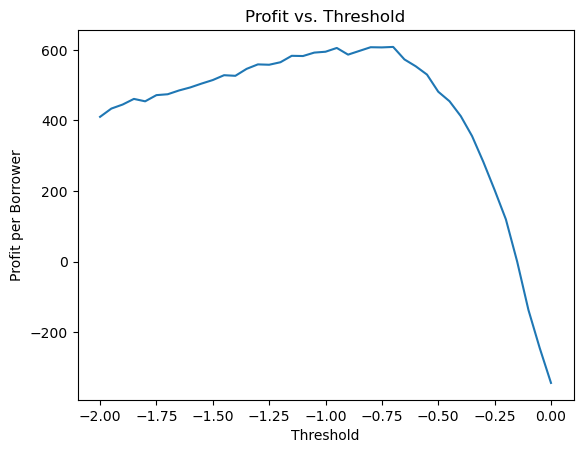

A threshold of -0.70 gives the maximum profit of $608.31 per borrower and an accuracy of 77%.


In [58]:
import numpy as np

# create columns for the profit of the bank if the loan is not defaulted and the cost if it is
X_train['profit'] = X_train["loan_amnt"]*(1 + 0.25*X_train["loan_int_rate"] * 0.01)**10 - X_train["loan_amnt"]
X_train['cost'] = X_train["loan_amnt"]*(1 + 0.25*X_train["loan_int_rate"] * 0.01)*3 - 1.7*X_train["loan_amnt"]

profit = []
acc = []

for t in np.linspace(-2, 0, 41):
    #if score <= t, they get the loan
    y_pred = X_train['score'] > t

    # when y_pred and y_train equal one, the bank correctly predicted a default and profit is 0
    # when y_pred and y_train equal zero, the bank correctly predicted a repaid loan and profit +X_train['profit']
    # when y_pred = 1, y_train = 0 the bank predicted a default and did not give the loan, so profit is 0
    # when y_pred = 0, y_train = 1 the bank incorrectly predicted the loan would be repaid, so profit is -X_train['cost']

    profit.append((((y_pred != y_train) * (y_pred == 0) * (-X_train['cost'])) + ((y_pred == y_train) * (y_pred == 0) * X_train['profit'])).mean())
    acc.append((y_pred == y_train).mean())

# making a plot of the threshold data from above loop
plt.plot(np.linspace(-2, 0, 41), profit)
plt.title("Profit vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Profit per Borrower")
plt.show()

t_best = -2 + np.argmax(np.array(profit)) * 0.05
print(f"A threshold of {t_best:.2f} gives the maximum profit of ${np.array(profit).max():.2f} per borrower and an accuracy of {acc[np.argmax(np.array(profit))]*100:.0f}%.")

Looking at the plot, we see that from the smallest threshold of -2, the profit rises slowly until it reaches a peak of just over $600 at t = -0.70 and then plummets steeply.

## Evaluating the model from the bank's perspective

In [59]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

In [60]:
X_test, y_test = prepare_data(df_test)

X_test['score'] = calc_score(X_test[cols_rfe], w)
X_test['profit'] = X_test["loan_amnt"]*(1 + 0.25*X_test["loan_int_rate"] * 0.01)**10 - X_test["loan_amnt"]
X_test['cost'] = X_test["loan_amnt"]*(1 + 0.25*X_test["loan_int_rate"] * 0.01)*3 - 1.7*X_test["loan_amnt"]


In [64]:
y_pred_test = X_test['score'] > t_best
avg_test_profit = ((((y_pred_test != y_test) * (y_pred_test == 0) * (-X_test['cost'])) + ((y_pred_test == y_test) * (y_pred_test == 0) * X_test['profit'])).mean())
test_acc = ((y_pred_test == y_test).mean())

print(f"A threshold of {t_best:.2f} on the test data set gives an average profit of ${avg_test_profit:.2f} per borrower and an accuracy of {test_acc*100:.0f}%.")

A threshold of -0.70 on the test data set gives an average profit of $472.68 per borrower and an accuracy of 77%.


Honestly, I feel pretty good about this. The expected profit for the test set is a bit over $150 less per person than that of the training data set. Additionally, the accuracy is exactly the same - yay!

## ... and the borrower's perspective?

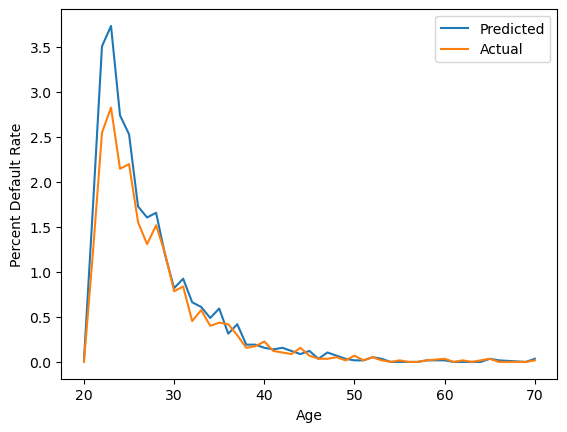

In [62]:
ages = X_test['person_age'].unique()
ages.sort()

pred_d_rates = []
actual_d_rates = []

for a in ages:
    pred_d_rates.append((y_pred_test * (a == X_test['person_age'])).mean() * 100)
    actual_d_rates.append((y_test * (a == X_test['person_age'])).mean() * 100)

fig, ax = plt.subplots()
ax.plot(ages, pred_d_rates, label="Predicted")
ax.plot(ages, actual_d_rates, label='Actual')
plt.ylabel("Percent Default Rate")
plt.xlabel("Age")
ax.legend()

It looks like the bank predicts a much higher rate of default for younger folks. This has a particularly strong impact on people in their 20s, but also seems to have some impact on people in their 30. As seen by the visual above, this does correlate reasonably well with an increased chance of an actual default among these ages.

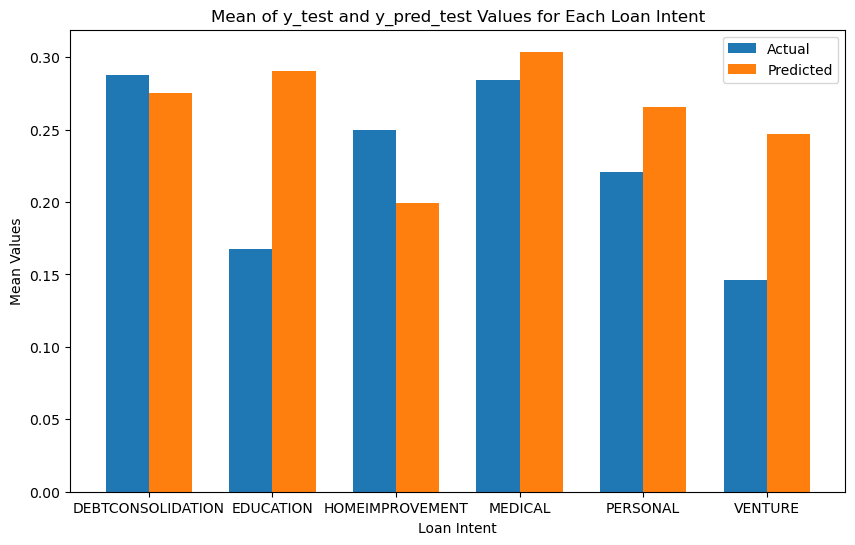

In [82]:
X_test['y_test'] = y_test
X_test['y_pred_test'] = y_pred_test

mean_values = X_test.groupby('loan_intent').agg({'y_test': 'mean', 'y_pred_test': 'mean'})

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(mean_values))

ax.bar(index, mean_values['y_test'], bar_width, label='Actual')
ax.bar(index + bar_width, mean_values['y_pred_test'], bar_width, label='Predicted')

ax.set_xlabel('Loan Intent')
ax.set_ylabel('Mean Values')
ax.set_title('Mean of y_test and y_pred_test Values for Each Loan Intent')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mean_values.index)
ax.legend()

plt.show()

This plot shows the actual and predicted mean rates of default based on loan intent. The higher a column is means the higher the chance of default, or the more data points where a default occurred (blue) or was predicted (orange), as defaulting is represented by 1 in this data set. We can see that medical loans have the highest predicted rate of default among all types of loan intent, which means medical loans are the least likely to be granted of any type of loan, or in other words, the most difficult to attain. In this category, its just a bit of an over-prediction of the actual rate of default. On the other hand, the rate of default for business ventures and education loans is steeply over predicted by the model compared to the actual rate.

[Text(0, 0.5, 'Income Percentile')]

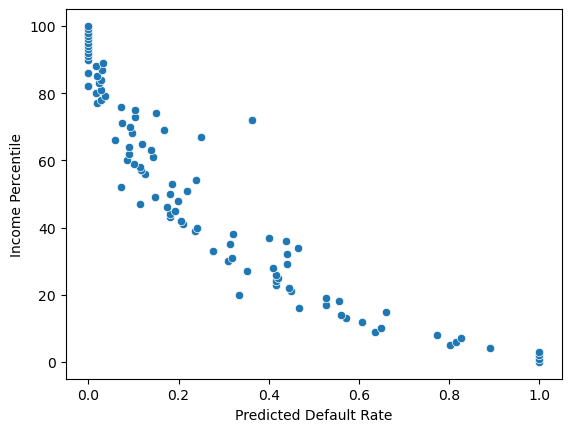

In [92]:
X_test['inc_percentile'] = round(X_test['person_income'].rank(pct = True), 2) * 100
grouped_data = X_test.groupby(['inc_percentile'])['y_pred_test'].mean()
grouped_data = pd.DataFrame(grouped_data)

ax = sns.scatterplot(data=grouped_data, x='y_pred_test', y='inc_percentile')
ax.set(xlabel = "Predicted Default Rate")
ax.set(ylabel = "Income Percentile")

This is... well, more or less the trend I expected. As the income percentile increases, so does the chance that the bank grants them a loan. This is seen by the more or less inverse relationship on the plot above.

In this blog post, I learned a lot about how difficult it can be to manipulate data with groupby functions to create effective plots. Keeping the number of points to a minimum can help make a clear point and avoid diluting with substantial amounts of noise. One technique to do this is splitting data up into percentiles. I also learned one method to find a good threshold. Finally, I learned that younger folks have more difficulty getting a loan (which makes some sense given their increased risk of default), that medical loans are the most difficult to get, and that business venture and education loans are the categories in which the bank most over-predicts the chance of default. Also, a higher income is a strong contributing factor to being granted a loan.

As mentioned earlier, it can be incredibly difficult to get a medical loan. In my opinion (supported by the middle view of fairness of Barocas, Hardt, and Narayanan), this is unfair. As they state, "this view holds that the decision makers have an obligation to avoid perpetuating injustice." Often times, individuals can be born with medical conditions. This is completely out of their control, and doesn't necessarily guarantee that they have the economic capital to pay for continuous treatment of said disease. In fact, I'd assume that there is a higher chance of being born into a high-risk medical group in lower income brackets, and by this logic, the middle view of fairness is blatantly violated by the difficulty to access medical loans regardless of whether they are paid back. 